In [1]:
import pandas as pd
import numpy as np
import math
import random
import re
import jieba
import jieba.analyse
from tqdm import tqdm
import lightgbm as lgb
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from nltk import word_tokenize
from sklearn.ensemble import GradientBoostingClassifier,GradientBoostingRegressor
from langconv import *
import pickle
import warnings
warnings.filterwarnings("ignore")

In [2]:
sensitive_words=pd.read_excel(r'F:\work\任务\2021.3.8 NLP\敏感词.xlsx')
sensitive_words_dict={}
for i in sensitive_words.index:
    word=sensitive_words['name'][i]
    cate=sensitive_words['type'][i]
    sensitive_words_dict.setdefault(cate,[])
    sensitive_words_dict[cate].append(word)
with open(r'F:\work\任务\2021.3.8 NLP\funNLP-master\data\敏感词库\色情词库.txt', 'r',encoding="utf-8") as f:
    for line in f:
        sensitive_words_dict['色情'].append(line.replace('\n',''))
f.close()
with open(r'F:\work\任务\2021.3.8 NLP\funNLP-master\data\敏感词库\敏感词.txt', 'r',encoding="utf-8") as f:
    for line in f:
        sensitive_words_dict.setdefault('其他',[])
        sensitive_words_dict['其他'].append(line.replace('\n',''))
f.close()
with open(r'F:\work\任务\2021.3.8 NLP\user_dict.txt', 'w',encoding="utf-8") as f:
    for k in sensitive_words_dict.keys():
        for v in sensitive_words_dict[k]:
            f.write(v)
            f.write('\n')
f.close()
#设置停用词
jieba.analyse.set_stop_words(r'F:\work\任务\2021.3.8 NLP\chinese_stopword.txt')
#设置userdict
jieba.load_userdict(r'F:\work\任务\2021.3.8 NLP\user_dict.txt')

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\JDD\AppData\Local\Temp\jieba.cache
Loading model cost 0.621 seconds.
Prefix dict has been built successfully.


In [21]:
tqdm.pandas(desc="my bar！")
origin_data = pd.read_csv(r'F:\work\任务\2021.3.8 NLP\export_processed_data.csv', encoding='UTF-8-sig')
origin_data.drop_duplicates(subset=['文本分词'], keep='first', inplace=True)
origin_data['色情敏感词数'] = origin_data['文本分词'].progress_apply(lambda i: get_sexy_words_count(i))
origin_data['博彩敏感词数'] = origin_data['文本分词'].progress_apply(lambda i: get_gamble_words_count(i))
origin_data['分词长度'] = origin_data['文本分词'].progress_apply(lambda i: get_length(i))
origin_data = origin_data.loc[origin_data['分词长度']>100]

my bar！: 100%|██████████| 78441/78441 [00:19<00:00, 3975.27it/s]


In [24]:
gambling_data = pd.read_csv(r'F:\work\任务\2021.3.8 NLP\processed_gamble_data.csv', encoding='UTF-8-sig')
sexy_data = pd.read_csv(r'F:\work\任务\2021.3.8 NLP\processed_sexy_data.csv', encoding='UTF-8-sig')
data = pd.concat([gambling_data, sexy_data], axis=0)
data['文本分词'] = data['清洗文本'].progress_apply(lambda i: jieba.cut(i))
data['文本分词'] = [' '.join(i) for i in data['文本分词']]
data['色情敏感词数'] = data['文本分词'].progress_apply(lambda i: get_sexy_words_count(i))
data['博彩敏感词数'] = data['文本分词'].progress_apply(lambda i: get_gamble_words_count(i))
data['分词长度'] = data['文本分词'].progress_apply(lambda i: get_length(i))
data.drop_duplicates(subset=['文本分词'], keep='first', inplace=True)

my bar！: 100%|██████████| 1966/1966 [00:00<00:00, 4429.52it/s]


In [13]:
def number_normalizer(tokens):
    """ 将所有数字标记映射为一个占位符（Placeholder）。
    对于许多实际应用场景来说，以数字开头的tokens不是很有用，
    但这样tokens的存在也有一定相关性。 通过将所有数字都表示成同一个符号，可以达到降维的目的。
    """
    return ("#NUMBER" if token[0].isdigit() else token for token in tokens)

def Traditional2Simplified(sentence):
    '''
    将sentence中的繁体字转为简体字
    :param sentence: 待转换的句子
    :return: 将句子中繁体字转换为简体字之后的句子
    '''
    sentence = Converter('zh-hans').convert(sentence)
    return sentence

#数据处理
httpcom = re.compile(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b')#去除网址
com_pre=re.compile(r"[a-zA-Z0-9/]+/")#去除com
com = re.compile(r"[a-zA-Z0-9/]+.com")
gif = re.compile(r"[a-zA-Z0-9/]+.gif")#去除gif
jpg = re.compile(r"[a-zA-Z0-9/]+.jpg")#去除jpg
png = re.compile(r"[a-zA-Z0-9/]+.png")#去除png
fil = re.compile('[’!"#$%&\'()*+,-./:：;<=>?@～，。?★☆©×»／、…【】《》『』「」←→（）？“”‘’！[\\]^_`{|}~]+', re.UNICODE)#去除特殊字符
space = re.compile(r' +')#多空格替换为一个空格

def data_procession(data):
    data=re.sub("[A-Za-z0-9\!\%\[\]\,\。]", " ", data)
    k=Traditional2Simplified(data).lower()
    k = httpcom.sub(' ',k)
    k = com_pre.sub(' ',k)
    k = com.sub(' ',k)
    k = gif.sub(' ',k)
    k = jpg.sub(' ',k)
    k = png.sub(' ',k)
    k = fil.sub(' ', k)
    k=k.replace('\n',' ')#去除换行符
    k=k.replace('\ufeff','')
    k=k.replace('\ue604','')
    k=k.replace('\ue6a9','')
    k=k.replace('\ue64c','')
    k=k.replace('\ue679','')
    k=k.replace('\ue608','')
    k = space.sub(' ',k)
    return k

def get_gamble_words_count(text):
    text=re.sub("[A-Za-z0-9\!\%\[\]\,\。]", "", text)
    tmp=list(set(text.split(' ')).intersection(set(sensitive_words_dict['博彩'])))
    return len(tmp)

def get_sexy_words_count(text):
    text=re.sub("[A-Za-z0-9\!\%\[\]\,\。]", "", text)
    tmp=list(set(text.split(' ')).intersection(set(sensitive_words_dict['色情'])))
    return len(tmp)

def get_gamble_words(text):
    text=re.sub("[A-Za-z0-9\!\%\[\]\,\。]", "", text)
    tmp=list(set(text.split(' ')).intersection(set(sensitive_words_dict['博彩'])))
    return tmp

def get_sexy_words(text):
    text=re.sub("[A-Za-z0-9\!\%\[\]\,\。]", "", text)
    tmp=list(set(text.split(' ')).intersection(set(sensitive_words_dict['色情'])))
    return tmp

def get_length(text):
    text=re.sub("[A-Za-z0-9\!\%\[\]\,\。]", "", text)
    tmp=list(filter(lambda x:x!='',text.split(' ')))
    return len(tmp)

In [45]:
g=pd.read_excel(r'F:\work\任务\2021.3.8 NLP\文本分类模型样例.xlsx',sheet_name='疑似样本')
g['色情敏感词数']=g['文本分词'].progress_apply(lambda i:get_sexy_words_count(i))
g['博彩敏感词数']=g['文本分词'].progress_apply(lambda i:get_gamble_words_count(i))
g['色情敏感词']=g['文本分词'].progress_apply(lambda i:get_sexy_words(i))
g['博彩敏感词']=g['文本分词'].progress_apply(lambda i:get_gamble_words(i))
g.to_excel(r'F:\work\任务\2021.3.8 NLP\tmp.xlsx')


my bar！: 100%|██████████| 10/10 [00:00<00:00, 3354.37it/s]

my bar！: 100%|██████████| 10/10 [00:00<00:00, 10005.50it/s]

my bar！: 100%|██████████| 10/10 [00:00<00:00, 3317.23it/s]

my bar！: 100%|██████████| 10/10 [00:00<00:00, 5015.91it/s]


In [28]:
origin_data=origin_data.loc[origin_data['分类']=='原始样本']
gambling_data=data.loc[data['分类']=='博彩负样本']
sexy_data=data.loc[data['分类']=='色情负样本']

In [3]:
origin_data = pd.read_csv(r'F:\work\任务\2021.3.8 NLP\export_processed_data_100.csv', encoding='UTF-8-sig')
origin_data

,分类,资产名称,资产url,文本数据,清洗文本,文本分词,色情敏感词数,博彩敏感词数,分词长度
0,原始样本,一佳口腔诊所,http://www.zjdgyj.com/a,### HTTP 错误 404.0 - Not Found\n\n#### 您要找的资源已被...,http 错误 404 0 not found 您要找的资源已被删除 已更名或暂时不可用 ...,http 错误 404 0 not found 您 要 找 的 ...,0,0,161
1,原始样本,一佳口腔诊所,http://www.zjdgyj.com/index.php,\n\n![](/Public/img/logo.jpg)\n\n * * 首页\n ...,首页 口腔知识 诊所介绍 案例展示 价格参考 诊疗项目 联系我们 1 2 3 my 牙齿说...,首页 口腔 知识 诊所 介绍 案例 展示 价格 参考 诊疗 项目 ...,0,0,459
2,原始样本,一佳口腔诊所,http://www.zjdgyj.com/'+strtmp+',### HTTP 错误 404.11 - Not Found\n\n#### 请求筛选模块被...,http 错误 404 11 not found 请求筛选模块被配置为拒绝包含双重转义序列...,http 错误 404 11 not found 请求 筛选 模...,0,0,174
3,原始样本,一佳口腔诊所,http://www.zjdgyj.com/a,### HTTP 错误 404.0 - Not Found\n\n#### 您要找的资源已被...,http 错误 404 0 not found 您要找的资源已被删除 已更名或暂时不可用 ...,http 错误 404 0 not found 您 要 找 的 ...,0,0,161
4,原始样本,一佳口腔诊所,http://www.zjdgyj.com/public/js/front_public.js,"$("".li_nav"").bind(""mouseover mouseout click"",f...",li nav bind mouseover mouseout click function...,li n av bind mo useover mo useout ...,1,0,725
...,...,...,...,...,...,...,...,...,...
879859,原始样本,乔讯电子科技（苏州）有限公司,http://www.joezon.com/page/offerlist.htm?trade...,### 招牌\n\n乔讯电子科技（苏州）有限公司 \n--- \n \n### 网站导...,招牌 乔讯电子科技 苏州 有限公司 网站导航 首页 供应产品 ▼ 公司档案 品牌介绍 样品...,招牌 乔讯 电子科技 苏州 有限公司 网站 导航 首页 供应 产...,1,0,2018
879860,原始样本,乔讯电子科技（苏州）有限公司,http://www.joezon.com/page/offerlist.htm?trade...,### 招牌\n\n乔讯电子科技（苏州）有限公司 \n--- \n \n### 网站导...,招牌 乔讯电子科技 苏州 有限公司 网站导航 首页 供应产品 ▼ 公司档案 品牌介绍 样品...,招牌 乔讯 电子科技 苏州 有限公司 网站 导航 首页 供应 产...,1,0,2018
879861,原始样本,乔讯电子科技（苏州）有限公司,http://www.joezon.com/page/offerlist.htm?trade...,### 招牌\n\n乔讯电子科技（苏州）有限公司 \n--- \n \n### 网站导...,招牌 乔讯电子科技 苏州 有限公司 网站导航 首页 供应产品 ▼ 公司档案 品牌介绍 样品...,招牌 乔讯 电子科技 苏州 有限公司 网站 导航 首页 供应 产...,1,0,2018
879862,原始样本,乔讯电子科技（苏州）有限公司,http://www.joezon.com/page/privatezone.htm,### 招牌\n\n乔讯电子科技（苏州）有限公司 \n--- \n \n### 网站导...,招牌 乔讯电子科技 苏州 有限公司 网站导航 首页 供应产品 ▼ 公司档案 品牌介绍 样品...,招牌 乔讯 电子科技 苏州 有限公司 网站 导航 首页 供应 产...,0,0,246


In [5]:
tqdm.pandas(desc="my bar！")
origin_data['色情敏感词数']=origin_data['文本分词'].progress_apply(lambda i:get_sexy_words_count(i))
origin_data['博彩敏感词数']=origin_data['文本分词'].progress_apply(lambda i:get_gamble_words_count(i))
origin_data['分词长度']=origin_data['文本分词'].progress_apply(lambda i:get_length(i))
origin_data=origin_data.loc[origin_data['分词长度']>100]
origin_data.drop_duplicates(subset=['文本分词'],keep='first',inplace=True)
origin_data

my bar！: 100%|██████████| 1156945/1156945 [03:52<00:00, 4971.13it/s] 


NameError: name 'data' is not defined

In [23]:
data.to_csv(r'F:\work\任务\2021.3.8 NLP\负样本-已清洗去重.csv',index=False)

In [ ]:
#正样本
origin_data_v1=pd.read_csv(r'F:\work\任务\2021.3.8 NLP\export_processed_data_100_unique.csv',encoding='UTF-8-sig')
origin_data_v2=pd.read_csv(r'F:\work\任务\2021.3.8 NLP\processed_positive_data.csv',encoding='UTF-8-sig')
tqdm.pandas(desc="my bar！")
origin_data_v2['文本分词'] = origin_data_v2['清洗文本'].progress_apply(lambda i:jieba.cut(i))
origin_data_v2['文本分词'] =[' '.join(i) for i in origin_data_v2['文本分词']]
origin_data_v2['色情敏感词数']=origin_data_v2['文本分词'].progress_apply(lambda i:get_sexy_words_count(i))
origin_data_v2['博彩敏感词数']=origin_data_v2['文本分词'].progress_apply(lambda i:get_gamble_words_count(i))
origin_data_v2['分词长度']=origin_data_v2['文本分词'].progress_apply(lambda i:get_length(i))
origin_data_v2=origin_data_v2.loc[origin_data_v2['分词长度']>100]
origin_data_v2.drop_duplicates(subset=['文本分词'],keep='first',inplace=True)
origin_data=pd.concat([origin_data_v1,origin_data_v2],axis=0)
origin_data.drop_duplicates(subset=['文本分词'],keep='first',inplace=True)

In [21]:
#负样本
gambling_data = pd.read_csv(r'F:\work\任务\2021.3.8 NLP\博彩负样本-已清洗.csv', encoding='UTF-8-sig')
sexy_data = pd.read_csv(r'F:\work\任务\2021.3.8 NLP\色情负样本-已清洗.csv', encoding='UTF-8-sig')
data = pd.concat([gambling_data, sexy_data], axis=0)
data['文本分词'] = data['清洗文本'].progress_apply(lambda i: jieba.cut(i))
data['文本分词'] = [' '.join(i) for i in data['文本分词']]
data['色情敏感词数'] = data['文本分词'].progress_apply(lambda i: get_sexy_words_count(i))
data['博彩敏感词数'] = data['文本分词'].progress_apply(lambda i: get_gamble_words_count(i))
data['分词长度'] = data['文本分词'].progress_apply(lambda i: get_length(i))
data.drop_duplicates(subset=['文本分词'], keep='first', inplace=True)
gambling_data=data.loc[data['分类']=='博彩负样本']
sexy_data=data.loc[data['分类']=='色情负样本']


my bar！: 100%|██████████| 1966/1966 [00:00<00:00, 64968.03it/s]

my bar！: 100%|██████████| 1966/1966 [00:00<00:00, 3662.45it/s]

my bar！: 100%|██████████| 1966/1966 [00:00<00:00, 5272.62it/s]

my bar！: 100%|██████████| 1966/1966 [00:00<00:00, 3821.82it/s]


In [ ]:
sus_data=pd.read_excel(r'F:\work\任务\2021.3.8 NLP\疑似样本.xlsx', encoding='UTF-8-sig')
tqdm.pandas(desc="my bar！")
sus_data['清洗文本'] = sus_data['文本数据'].progress_apply(lambda i:data_procession(i))
sus_data['文本分词'] = sus_data['清洗文本'].progress_apply(lambda i:jieba.cut(i))
sus_data['文本分词'] =[' '.join(i) for i in sus_data['文本分词']]
sus_data['色情敏感词数']=sus_data['文本分词'].progress_apply(lambda i:get_sexy_words_count(i))
sus_data['博彩敏感词数']=sus_data['文本分词'].progress_apply(lambda i:get_gamble_words_count(i))
sus_data['分词长度']=sus_data['文本分词'].progress_apply(lambda i:get_length(i))
sus_data['分类']='正样本'
sus_data=sus_data[['分类','资产名称','资产url','文本数据','清洗文本','文本分词','色情敏感词数','博彩敏感词数','分词长度']]
sus_data

In [5]:
tqdm.pandas(desc="my bar！")
test_data['文本分词'] = test_data['清洗文本'].progress_apply(lambda i:jieba.cut(i))
test_data['文本分词'] =[' '.join(i) for i in test_data['文本分词']]
test_data['色情敏感词数']=test_data['文本分词'].progress_apply(lambda i:get_sexy_words_count(i))
test_data['博彩敏感词数']=test_data['文本分词'].progress_apply(lambda i:get_gamble_words_count(i))
test_data['分词长度']=test_data['文本分词'].progress_apply(lambda i:get_length(i))
#test_data['标记']='第一版原始样本'
#test_data=pd.concat([test_data,first_data],axis=0)
data=pd.read_csv(r'F:\work\任务\2021.3.8 NLP\负样本-已清洗去重.csv', encoding='UTF-8-sig')
gambling_data=data.loc[data['分类']=='博彩负样本']
sexy_data=data.loc[data['分类']=='色情负样本']

my bar！: 100%|██████████| 119852/119852 [00:50<00:00, 2366.67it/s]


In [3]:
#读取测试集
test_data=pd.read_csv(r'F:\work\任务\2021.3.8 NLP\测试集.csv', encoding='UTF-8-sig')
test_data
#test_data['分类']='正样本'
#test_df, test1 = train_test_split(test_data, test_size=1/5)
#test_df, test2 = train_test_split(test_df, test_size=1/4)
#test_df, test3 = train_test_split(test_df, test_size=1/3)
#test5, test4 = train_test_split(test_df, test_size=1/2)
#test_data=[]

,分类,资产名称,资产url,文本数据,清洗文本,文本分词,色情敏感词数,博彩敏感词数,分词长度
0,原始样本,csdhhg.com,http://www.csdhhg.com/news/53933.html,# 沙巴体育体育游戏_lol下注盘口网站:BBIN彩票游戏\n\n**东坡下载：内容最丰富最...,沙巴体育体育游戏 lol下注盘口网站 bbin彩票游戏 东坡下载 内容最丰富最安全的下载站...,沙巴体育 体育 游戏 lol 下注 盘口 网站 bbin 彩票 游戏 东坡 ...,1,3,1763
1,原始样本,tiantuowaji.com,http://www.tiantuowaji.com/tv38vf4k/51oaw3l/,![大门户](/template/news/n2/static/picture/logo.p...,大门户 新闻 军事 国内 国际 财经 基金 外汇 股票 体育 女排 中超 英超 汽车 购车...,大 门户 新闻 军事 国内 国际 财经 基金 外汇 股票...,1,2,1563
2,原始样本,gwardening.com,http://www.gwardening.com/?tag=www.657471.com,![书院家园](\\data\\upload\\2018-11-03\\5bdd555af0...,书院家园 \\data\\upload\\2018 11 03\\ 美文 散文 故事 作文...,书院 家园 \ \ da ta \ \ upload \ \ 2018 11 ...,1,1,1356
3,原始样本,苏州市吴江区总工会(web),http://wjzgh.gov.cn/newstext2.asp?xjwid=2881,|\n\n| \n---|--- \n| | ![](images/server.gi...,站内检索 info info ◎ 首页 新闻中心 图片新闻 盛泽镇开展机关工会风采才艺大赛...,站 内 检索 info info ◎ 首页 新闻 中心 图片 新...,0,0,209
4,原始样本,镇江市体育局,http://tjj.zhenjiang.gov.cn/./tjyw/zbjs/,| ![](../../images/zj_tjj_index_logo.gif) | |...,zj tjj index 简体 本站检索 全站检索 zj tjj index search...,zj tjj index 简体 本站 检索 全站 检索 zj ...,0,0,148
...,...,...,...,...,...,...,...,...,...
355074,原始样本,szqts.gov.cn,http://www.szqts.gov.cn/banshizhinan15/d9bbab2...,今天是2019年10月28日 苏州市市场监督管理局欢迎您！ 政务电话：0512-698516...,今天是2019年10月28日 苏州市市场监督管理局欢迎您 政务电话 0512 6985160...,今天 是 2019 年 10 月 28 日 苏州市 市场 监督 管理局 欢迎您 政务...,0,0,169
355075,原始样本,甪直实小,http://www.wzlzsyxx.com/yey/yszx/content_180224,* ### 网站首页\n\n * ### 学校概况\n\n * ### 学校...,网站首页 学校概况 学校介绍 校园文化 办学成果 大事记录 党建工团 党建园地 教工之家 ...,网站 首页 学校 概况 学校 介绍 校园文化 办学 成果 大事 记录...,0,0,597
355076,原始样本,chaumajt.com,http://www.chaumajt.com/63vhx/,__文章导航 ~~~~_PC6首页软件下载单机游戏安卓资源苹果资源_\n\n**pc软件**...,文章导航 pc6首页软件下载单机游戏安卓资源苹果资源 pc软件 新闻网络操作系统办公工具编...,文章 导航 pc6 首页 软件 下载 单机游戏 安卓 资源 苹果 资源 pc 软...,0,3,1651
355077,原始样本,gwardening.com,http://www.gwardening.com/?tag=www.17.pw,![书院家园](\\data\\upload\\2018-11-03\\5bdd555af0...,书院家园 \\data\\upload\\2018 11 03\\ 美文 散文 故事 作文...,书院 家园 \ \ da ta \ \ upload \ \ 2018 11 ...,1,1,1352


In [4]:
train_data=pd.read_csv(r'F:\work\任务\2021.3.8 NLP\训练集.csv', encoding='UTF-8-sig')

train_data

,分类,资产名称,资产url,文本数据,清洗文本,文本分词,色情敏感词数,博彩敏感词数,分词长度
0,原始样本,苏州工业园区源得福劳务派遣服务有限公司,http://www.chinayuandefu.com/shownews.asp?id=44,| ![江苏省源得福服务外包集团](UploadFiles/20176818185186.j...,江苏省源得福服务外包集团 网站首页 关于我们 公司简介 企业文化 服务领域 员工生活 新闻...,江苏省 源得福 服务 外包 集团 网站 首页 关于 我们 公司简介 企业...,0,0,326
1,原始样本,中国共产党苏州市吴江区委员会党校（1）(web),http://www.wjdx.gov.cn/tongji.ashx?category=19...,//AJax var requests = new Array(); if(typeof(X...,ajax var requests new array if typeof xmlhttp...,ajax var requests new array if t...,1,0,150
2,原始样本,dblwjjx.com,http://www.dblwjjx.com/ozo7ta5i/kpjiqn/,![大门户](/template/news/n2/static/picture/logo.p...,大门户 新闻 军事 国内 国际 财经 基金 外汇 股票 体育 女排 中超 英超 汽车 购车...,大 门户 新闻 军事 国内 国际 财经 基金 外汇 股票...,0,1,1610
3,原始样本,tiantuowaji.com,http://www.tiantuowaji.com/list11186/,![](/template/news/n1/static/picture/logo.png)...,新闻 军事 国内 国际 财经 基金 外汇 股票 体育 女排 中超 英超 汽车 购车 用车 ...,新闻 军事 国内 国际 财经 基金 外汇 股票 体育 ...,0,1,1257
4,原始样本,dblwjjx.com,http://www.dblwjjx.com/jocjc3h/195631.html,![大门户](/template/news/n2/static/picture/logo.p...,大门户 新闻 军事 国内 国际 财经 基金 外汇 股票 体育 女排 中超 英超 汽车 购车...,大 门户 新闻 军事 国内 国际 财经 基金 外汇 股票...,0,1,1518
...,...,...,...,...,...,...,...,...,...
354995,原始样本,csdhhg.com,http://www.csdhhg.com/ios/97313.html,# 沙巴体育体育游戏_lol下注盘口网站:BBIN彩票游戏\n\n_东坡下载：内容最丰富最安...,沙巴体育体育游戏 lol下注盘口网站 bbin彩票游戏 东坡下载 内容最丰富最安全的下载站...,沙巴体育 体育 游戏 lol 下注 盘口 网站 bbin 彩票 游戏 东坡 ...,0,3,1453
354996,原始样本,丹徒人才网,https://www.dtrsrc.com/junshi/6248.html,* 头条\n * 国内\n * 国际\n * 图片\n * 社会\n * 娱乐...,头条 国内 国际 图片 社会 娱乐 教育 军事 科技 财经 时尚 体育 滚动 人文 健康 ...,头条 国内 国际 图片 社会 娱乐 教育 军事 科技 ...,0,0,597
354997,原始样本,苏州盛泽东方会展有限公司2（web）,http://www.shengzenews.cn/Details/124481.html,![](/images/h.jpg) 盛泽丝绸文化旅游网首页\n\n * 我爱盛泽微信公众...,盛泽丝绸文化旅游网首页 我爱盛泽微信公众号 扫一扫关注 我爱盛泽 微信公众号 新闻 要闻 ...,盛泽 丝绸 文化 旅游网 首页 我 爱 盛泽微信 公众 号 扫一扫 关注 我...,0,0,454
354998,原始样本,苏州酷德信息科技有限公司,http://www.codegame.cn/show/911797.html,![](/uploads/images/logo.png?n=5gk372fcs3sznbh...,n 5gk372fcs3sznbhircpoppmr w 230 网站首页 何伶 林佑威 ...,n 5gk372f cs 3sznbhircpoppmr w 230 网...,1,0,2568


In [6]:
data=data.sort_values(by='资产名称')
data

,分类,资产名称,资产url,文本数据,清洗文本,文本分词,色情敏感词数,博彩敏感词数,分词长度
232508,原始样本,005wan,http://www.005wan.com/qxzb/83.html,# 005wan游戏平台\n\n * 平台首页\n * 账号登录\n * 游戏大厅\n...,005wan游戏平台 平台首页 账号登录 游戏大厅 游戏资讯 新手礼包 家长监护 当前位置...,005wan 游戏 平台 平台 首页 账号 登录 游戏 大厅 游戏 资讯...,0,0,318
234554,原始样本,005wan,http://www.005wan.com/tlcs/34.html,# 005wan游戏平台\n\n * 平台首页\n * 账号登录\n * 游戏大厅\n...,005wan游戏平台 平台首页 账号登录 游戏大厅 游戏资讯 新手礼包 家长监护 当前位置...,005wan 游戏 平台 平台 首页 账号 登录 游戏 大厅 游戏 资讯...,0,0,358
46181,原始样本,005wan,http://www.005wan.com/lhzs/2.html,# 005wan游戏平台\n\n * 平台首页\n * 账号登录\n * 游戏大厅\n...,005wan游戏平台 平台首页 账号登录 游戏大厅 游戏资讯 新手礼包 家长监护 当前位置...,005wan 游戏 平台 平台 首页 账号 登录 游戏 大厅 游戏 资讯...,0,0,383
110665,原始样本,005wan,http://www.005wan.com/lhzs/4.html,# 005wan游戏平台\n\n * 平台首页\n * 账号登录\n * 游戏大厅\n...,005wan游戏平台 平台首页 账号登录 游戏大厅 游戏资讯 新手礼包 家长监护 当前位置...,005wan 游戏 平台 平台 首页 账号 登录 游戏 大厅 游戏 资讯...,0,0,397
21033,原始样本,005wan,http://www.005wan.com/sxd/110.html,# 005wan游戏平台\n\n * 平台首页\n * 账号登录\n * 游戏大厅\n...,005wan游戏平台 平台首页 账号登录 游戏大厅 游戏资讯 新手礼包 家长监护 当前位置...,005wan 游戏 平台 平台 首页 账号 登录 游戏 大厅 游戏 资讯...,0,0,144
...,...,...,...,...,...,...,...,...,...
329554,原始样本,NaN,http://www.sz96333.org/law/9f1026f9141ce2b96e3...,今天是2021年03月01日 苏州市电梯应急救援指挥中心欢迎您！ 24小时应急救援电话：96...,今天是2021年03月01日 苏州市电梯应急救援指挥中心欢迎您 24小时应急救援电话 963...,今天 是 2021 年 03 月 01 日 苏州市 电梯 应急 救援 指挥中心 欢迎您 ...,1,1,2476
336026,原始样本,NaN,http://www.cpeis.org/newsinfo.aspx?nid=1511271...,![](images/icon1.png)设为首页| ![](images/icon2.pn...,设为首页 加入收藏 平台使用手册 您好 欢迎来到新兴产业标准化 苏州 协作平台 首页 工作...,设 为 首页 加入收藏 平台 使用手册 您好 欢迎 来到 新兴产业 标准...,0,1,271
339510,原始样本,NaN,http://www.szjl.com.cn/ability.html?category=j...,搜索\n\n计量首页 党建工作 关于我们 服务中心 强检免征 联系我们\n\n当前位置:首页...,搜索 计量首页 党建工作 关于我们 服务中心 强检免征 联系我们 当前位置 首页 资质能力 ...,搜索 计量 首页 党建 工作 关于 我们 服务中心 强检 免征 联系...,1,0,337
342681,原始样本,NaN,http://scjgj.suzhou.gov.cn/szqts/zhxx/202102/7...,您当前所在位置： 首页>新闻中心>综合信息\n\n市计量测试院召开2020年总结表彰暨202...,您当前所在位置 首页 新闻中心 综合信息 市计量测试院召开2020年总结表彰暨2021年目标...,您 当前 所在位置 首页 新闻 中心 综合信息 市 计量 测试 院 召开 2...,1,0,297


In [7]:
train_data=data[:355000]
test_data=data[355000:]

In [11]:
train_data['分类']='正样本'
test_data['分类']='正样本'

In [9]:
train_data.to_csv(r'F:\work\任务\2021.3.8 NLP\train_data.csv', encoding='UTF-8-sig',index=False)
print('训练集ready')
test_data.to_csv(r'F:\work\任务\2021.3.8 NLP\test_data.csv', encoding='UTF-8-sig',index=False)
print('测试集ready')

KeyboardInterrupt: 

In [ ]:
test_data.to_csv(r'F:\work\任务\2021.3.8 NLP\test_data.csv', encoding='UTF-8-sig',index=False)

In [4]:
#读取正样本
train_data=pd.read_csv(r'F:\work\任务\2021.3.8 NLP\训练集.csv', encoding='UTF-8-sig')
train_data['分类']='正样本'

In [14]:
#读取负样本
tqdm.pandas(desc="my bar！")
n=pd.read_excel(r'F:\work\任务\2021.3.8 NLP\第一版原始样本标注2.xlsx', encoding='UTF-8-sig')
n['分词长度']=n['文本分词'].progress_apply(lambda i:get_length(i))
gamble=n.loc[n['分类']=='博彩负样本']
sex=n.loc[n['分类']=='色情负样本']
p=n.loc[n['分类']=='正样本']
data=pd.read_csv(r'F:\work\任务\2021.3.8 NLP\负样本-已清洗去重.csv', encoding='UTF-8-sig')
data['分词长度']=data['文本分词'].progress_apply(lambda i:get_length(i))
gambling_data=data.loc[data['分类']=='博彩负样本']
sexy_data=data.loc[data['分类']=='色情负样本']
sexy_data=pd.concat([sex,sexy_data[sex.columns]],axis=0)
gambling_data=pd.concat([gamble,gambling_data[gamble.columns]],axis=0)


my bar！: 100%|██████████| 28142/28142 [00:09<00:00, 2917.42it/s]

my bar！: 100%|██████████| 1829/1829 [00:00<00:00, 3346.51it/s]


In [ ]:
# 制作数据集
pos_data = train_data.loc[train_data['博彩敏感词数'] == 0]
pos_sample = pos_data.sample(50000)
pos_sample = pd.concat([pos_sample, sexy_data,p], axis=0)  # 从原始样本抽取5W,与博彩样本作为正样本
pos_sample['分类'] = '正样本'
neg_sample = gambling_data  # 色情样本作为负样本
train = pd.concat([pos_sample, neg_sample], axis=0)[train_data.columns]

# 训练模型

In [54]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    """对数损失度量（Logarithmic Loss Metric）的多分类版本。
    :param actual: 包含actual target classes的数组
    :param predicted: 分类预测结果矩阵, 每个类别都有一个概率
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota



def mix_matrix(actual,predicted):
    act_cate=np.unique(actual)
    pre_cate=np.unique(predicted)
    mix_mtx=np.zeros(shape=(len(act_cate),len(pre_cate)))
    for i in range(len(actual)):
        act=actual[i]
        pre=predicted[i]
        act_index=int(np.argwhere(act_cate==act))
        pre_index=int(np.argwhere(pre_cate==pre))
        mix_mtx[act_index][pre_index]+=1
    df=pd.DataFrame(mix_mtx,columns=pre_cate,index=act_cate,dtype=int)
    return df

In [67]:
lbl_enc = preprocessing.LabelEncoder()
lbl_enc.fit(train['分类'].values)
y = lbl_enc.transform(train['分类'].values)

In [61]:
#pickle.dump(lbl_enc, open(r"F:\work\任务\2021.3.8 NLP\model\LabelEncoder_gam.pickle", "wb"))

In [74]:
xtrain, xvalid, ytrain, yvalid = train_test_split(train, y, 
                                                  stratify=y, 
                                                  random_state=42, 
                                                  test_size=0.2, shuffle=True)
print (xtrain.shape)
print (xvalid.shape)

(63976, 9)
(15995, 9)


In [17]:
def number_normalizer(tokens):
    """ 将所有数字标记映射为一个占位符（Placeholder）。
    对于许多实际应用场景来说，以数字开头的tokens不是很有用，
    但这样tokens的存在也有一定相关性。 通过将所有数字都表示成同一个符号，可以达到降维的目的。
    """
    return ("#NUMBER" if token[0].isdigit() else token for token in tokens)
class NumberNormalizingVectorizer(TfidfVectorizer):
    def build_tokenizer(self):
        tokenize = super(NumberNormalizingVectorizer, self).build_tokenizer()
        return lambda doc: list(number_normalizer(tokenize(doc)))
stwlist=[line.strip() for line in open(r'F:\work\任务\2021.3.8 NLP\chinese_stopword.txt','r',encoding='utf-8').readlines()]

In [1]:
tfv = NumberNormalizingVectorizer(min_df=50,  
                                  max_df=0.5,
                                  max_features=None,                 
                                  ngram_range=1, 
                                  use_idf=True,
                                  smooth_idf=True,
                                  stop_words = stwlist)

# 使用TF-IDF来fit训练集和测试集（半监督学习）
tfv.fit(list(xtrain.文本分词.values) + list(xvalid.文本分词.values))
xtrain_tfv =  tfv.transform(xtrain.文本分词.values) 
xvalid_tfv = tfv.transform(xvalid.文本分词.values)
print(xtrain_tfv.shape)

NameError: name 'NumberNormalizingVectorizer' is not defined

In [ ]:
#pickle.dump(tfv, open(r"F:\work\任务\2021.3.8 NLP\model\tfidf_10W50_sex.pickle", "wb"))
tfv=pickle.load(open(r"F:\work\任务\2021.3.8 NLP\model\tfidf_5W20_gamble.pickle",'rb'),encoding='iso-8859-1')
clf=pickle.load(open(r"F:\work\任务\2021.3.8 NLP\model\gbdt_5W20_gamble_4.pkl",'rb'),encoding='iso-8859-1')

In [27]:
test_df = sus_data  # test2/test3/test4
xtest_tfv = tfv.transform(test_df.文本分词.values)
#ytest = lbl_enc.transform(test_df['分类'].values)
ytest = test_df['分类'].values
predictions_proba = clf.predict_proba(xtest_tfv)
predictions = clf.predict(xtest_tfv)
#y_pre = lbl_enc.inverse_transform(predictions)  # 将模型预测的结果转为中文分类（0/1-->正样本/色情负样本）
#y_org = lbl_enc.inverse_transform(ytest)
#mix_matrix(y_org,y_pre)

In [31]:
test_df['分类']=predictions
test_df['涉黄概率']=predictions_proba[:,1]
test_df

,分类,资产名称,资产url,文本数据,清洗文本,文本分词,色情敏感词数,博彩敏感词数,分词长度,涉黄概率
0,正样本,吴xxxx医院,http://www.wzrm-hospital.com/article/1585.html,* 首 页\n * 医院概况\n * 医院介绍\n * 领导班子\n ...,首 页 医院概况 医院介绍 领导班子 科室介绍 专家简介 院务公开 医疗政策 服务指南 服...,首 页 医院 概况 医院 介绍 领导班子 科室 介绍 专家 简介...,1,0,1190,0.000883
1,正样本,吴xxxx医院,http://www.wzrm-hospital.com/article/1748.html,* 首 页\n * 医院概况\n * 医院介绍\n * 领导班子\n ...,首 页 医院概况 医院介绍 领导班子 科室介绍 专家简介 院务公开 医疗政策 服务指南 服...,首 页 医院 概况 医院 介绍 领导班子 科室 介绍 专家 简介...,1,0,487,0.002111
2,正样本,吴xxxx医院,http://www.wzrm-hospital.com/article/1761.html,* 首 页\n * 医院概况\n * 医院介绍\n * 领导班子\n ...,首 页 医院概况 医院介绍 领导班子 科室介绍 专家简介 院务公开 医疗政策 服务指南 服...,首 页 医院 概况 医院 介绍 领导班子 科室 介绍 专家 简介...,2,0,671,0.002136
3,正样本,吴xxxx医院,http://www.wzrm-hospital.com/article/1592.html,* 首 页\n * 医院概况\n * 医院介绍\n * 领导班子\n ...,首 页 医院概况 医院介绍 领导班子 科室介绍 专家简介 院务公开 医疗政策 服务指南 服...,首 页 医院 概况 医院 介绍 领导班子 科室 介绍 专家 简介...,1,0,688,0.001541
4,正样本,吴xxxx医院,http://www.wzrm-hospital.com/article/1756.html,* 首 页\n * 医院概况\n * 医院介绍\n * 领导班子\n ...,首 页 医院概况 医院介绍 领导班子 科室介绍 专家简介 院务公开 医疗政策 服务指南 服...,首 页 医院 概况 医院 介绍 领导班子 科室 介绍 专家 简介...,1,0,608,0.000848
5,正样本,吴xxxx医院,http://www.wzrm-hospital.com/article/alist27_1...,* 首 页\n * 医院概况\n * 医院介绍\n * 医院章程\n ...,首 页 医院概况 医院介绍 医院章程 领导班子 科室介绍 专家简介 院务公开 医疗政策 服...,首 页 医院 概况 医院 介绍 医院 章程 领导班子 科室 介绍...,1,0,350,0.006532
6,正样本,苏州独墅湖科教发展有限公司,http://www.215123.cn/tzgg/17440.jhtml,* 首页\n * 今慧湖\n * 直播慧湖\n * 区域速览\n *...,首页 今慧湖 直播慧湖 区域速览 慧湖指南 慧湖荣耀 慧学习 院校风采 慧湖学院 慧湖书院...,首页 今慧湖 直播 慧湖 区域 速览 慧湖 指南 慧湖 荣耀 慧...,0,0,628,0.000503
7,色情负样本,吴xxxx医院,http://www.wzrm-hospital.com/keshi/28.html,* 首 页\n * 医院概况\n * 医院介绍\n * 医院章程\n ...,首 页 医院概况 医院介绍 医院章程 领导班子 科室介绍 专家简介 院务公开 医疗政策 服...,首 页 医院 概况 医院 介绍 医院 章程 领导班子 科室 介绍...,2,0,569,0.705300
8,正样本,安全服务中心测试网站资产,http://xsc.jzmu.edu.cn/info/1015/1034.htm,?\n\n![学生工作处](../../dfiles/11354/templates/gzb...,学生工作处 header 机构设置 部门概况 组织机构 工作职责 思政教育 易班建设 规章...,学生 工作 处 header 机构 设置 部门 概况 组织 机构 工...,1,0,1447,0.001760
9,正样本,吴xxxx医院,http://www.wzrm-hospital.com/article/1301.html,* 首 页\n * 医院概况\n * 医院介绍\n * 领导班子\n ...,首 页 医院概况 医院介绍 领导班子 科室介绍 专家简介 院务公开 医疗政策 服务指南 服...,首 页 医院 概况 医院 介绍 领导班子 科室 介绍 专家 简介...,1,0,438,0.001787


In [32]:
test_df.to_excel(r'F:\work\任务\2021.3.8 NLP\疑似样本样例.xlsx',index=False,encoding='utf-8-sig')

In [188]:
#grid search最优参数
#param_test1 = {'n_estimators':range(20,81,10)}
#param_test2 = {'max_depth':range(3,14,2), 'min_samples_split':range(100,801,200)}
#gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60,
#                                  min_samples_leaf=20,max_features='sqrt', subsample=0.8,random_state=10), 
#                       param_grid = param_test2, scoring='accuracy',iid=False,cv=5)
#gsearch1.fit(xtrain_tfv, ytrain)
#gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([58.54895525, 58.36295724, 58.43079147, 53.62251177, 52.76176023,
         52.67645831, 53.02089195, 53.25836043, 54.00981274, 53.8958384 ,
         53.95322037, 54.08334336, 55.31690712, 57.86357021, 59.75101185,
         60.2952517 , 61.63656254, 59.39098282, 60.43875608, 60.81592212,
         62.70681081, 57.7116066 , 55.43303046, 55.68765116]),
  'std_fit_time': array([0.42405708, 0.63221815, 0.2874443 , 2.68531533, 0.21271392,
         0.21688864, 0.38740493, 0.16347771, 0.13634747, 0.13702156,
         0.28638347, 0.26564246, 0.68729173, 1.20768367, 0.46733791,
         0.80378816, 0.55009355, 0.70331993, 0.67912988, 0.78259958,
         0.24416257, 3.30245876, 7.37977346, 4.6455123 ]),
  'mean_score_time': array([0.03210826, 0.03075008, 0.03137612, 0.02859793, 0.03366895,
         0.0318121 , 0.03220754, 0.03094373, 0.03807297, 0.03690567,
         0.03611298, 0.03572798, 0.04471369, 0.04293799, 0.04627013,
         0.04558973, 0.05125341, 0.04937091, 0.

In [321]:
#验证集预测
clf = LogisticRegression(C=1.0,solver='lbfgs',multi_class='multinomial')
#clf = MultinomialNB()
#clf = GradientBoostingClassifier(learning_rate=0.1, n_estimators=80,max_depth=13,min_samples_split=500,min_samples_leaf=20,max_features='sqrt', subsample=0.8)
# 模型训练
#clf = GradientBoostingClassifier(n_estimators=20)
clf.fit(xtrain_tfv, ytrain)
predictions_proba = clf.predict_proba(xtrain_tfv)
predictions = clf.predict(xtrain_tfv)
y_pre = lbl_enc.inverse_transform(predictions)  # 将模型预测的结果转为中文分类（0/1-->正样本/色情负样本）
y_org = lbl_enc.inverse_transform(ytrain)
mix_matrix(y_org,y_pre)

,正样本,色情负样本
正样本,99622,2
色情负样本,20,4332


In [322]:
np.argwhere((ytrain-predictions)!=0)

array([[ 2986],
       [ 3910],
       [ 4358],
       [ 4976],
       [ 6240],
       [10454],
       [22765],
       [25373],
       [30581],
       [45603],
       [49036],
       [50982],
       [57863],
       [60987],
       [61904],
       [67813],
       [72484],
       [72823],
       [76458],
       [88441],
       [91248],
       [91758]], dtype=int64)

In [327]:
i=4976
print('预测分类为：',y_pre[i])
print('原始分类为：',y_org[i])
print(pd.DataFrame(predictions_proba[i].reshape(1,2),columns=lbl_enc.classes_))
print(test_df.iloc[i]['资产url'])
print(test_df.iloc[i]['色情敏感词数'])
print(test_df.iloc[i]['文本分词'])

预测分类为： 正样本
原始分类为： 色情负样本
        正样本     色情负样本
0  0.985155  0.014845
http://www.tiantuowaji.com/v36avvx/198624/
1
  大 门户   新闻   军事   国内   国际   财经   基金   外汇   股票   体育   女排   中超   英超   汽车   购车   用车   测评   房产   新房   装修   家居   科技   手机   探索   智能   旅游   攻略   文化   自驾   时尚   亲子   女人   流行   教育   高考   公益   佛学   美食   菜谱   食材   健康   娱乐   电视剧   博客   自 媒体   新闻   财经   体育   汽车   房产   科技   旅游   时尚   教育   美食   博客   娱乐   您 的 位置   首页   腾讯 娱乐   南方 双彩 旧版本 下载   南方 双彩 旧版本 下载   欢迎 来到   南方 双彩 旧版本 下载   作者   浙里 丽水   来源   南方 双彩 旧版本 下载   2019   10   15   12   32   阅读 869   南方 双彩 旧版本 下载 文章 称   如果 问题 在 未来 几周 内 依然 得不到 解决   欧洲 的 电信 运营商 就 不得不 寻找 替代 方案   以免 它们 的 5g 网络 投资 和 建设 计划 彻底 泡汤   也就是说   世人 的 目光 应该 投向 美国 与 中国 对抗 的 真正 全球 受害者   欧洲 的 第五代 移动 通信 网络   南方 双彩 旧版本 下载   南方 双彩 旧版本 下载 介绍   新 的 图景 带来 新 的 期待   去年底   广东省 印发 的   珠江 西岸 先进 装备 制造 产业带 聚焦 攻坚 行动计划   2018 — 2020 年   指出   要 推动 珠江 西岸 迈入 全球 制造业 第二 梯队   将 珠江 西岸地区 打 造成 装备 制造业 产值 2 万亿元   具有 世界 影响力 和 国际 竞争力 的 先进 装备 制造业 基地   南方 双彩 旧版本 下载 介绍   ucimg   php   img ur l   新 京报 讯   记者 

In [ ]:
# 异常样本处理
pos_idx = lbl_enc.transform(['正样本'])[0]
#gam_idx=lbl_enc.transform(['博彩负样本'])[0]
sex_idx = lbl_enc.transform(['色情负样本'])[0]
delete_cols = []
for i in range(predictions_proba.shape[0]):
    if predictions_proba[i][pos_idx] < 0.8:
        if predictions_proba[i][sex_idx] >= 0.8:
            ytrain[i] = sex_idx
        else:
            delete_cols.append(i)
xtrain=xtrain.reset_index(drop=True)
xtrain.drop(xtrain.index[delete_cols], axis=0, inplace=True)
ytrain=np.delete(ytrain, delete_cols,0)
print(len(xtrain))
print(ytrain.shape)

In [342]:
#LGB
xtrain_tfv = tfv.transform(xtrain.文本分词.values)
print(xtrain_tfv.shape)
lgb_train = lgb.Dataset(xtrain_tfv, ytrain)
lgb_valid = lgb.Dataset(xvalid_tfv, yvalid, reference=lgb_train)
params = {
    'task': 'train',
    'is_unbalance':'True',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 1
}
gbm =lgb.train(params,
                lgb_train,
                num_boost_round=10,
                valid_sets=lgb_valid,
                early_stopping_rounds=5)
test_df=test3
xtest_tfv=tfv.transform(test_df.文本分词.values)
ytest = lbl_enc.transform(test_df['分类'].values)
predictions_proba=gbm.predict(xtest_tfv)
predictions=[1 if x>=0.5 else 0 for x in predictions_proba]
y_pre = lbl_enc.inverse_transform(predictions)  # 将模型预测的结果转为中文分类（0/1-->正样本/色情负样本）
y_org = lbl_enc.inverse_transform(ytest)
mix_matrix(y_org, y_pre)

(103970, 218834)
[1]	valid_0's binary_logloss: 0.126023
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.110097
[3]	valid_0's binary_logloss: 0.0988651
[4]	valid_0's binary_logloss: 0.0900561
[5]	valid_0's binary_logloss: 0.0827519
[6]	valid_0's binary_logloss: 0.076524
[7]	valid_0's binary_logloss: 0.0710724
[8]	valid_0's binary_logloss: 0.0662619
[9]	valid_0's binary_logloss: 0.0619305
[10]	valid_0's binary_logloss: 0.0580152
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.0580152


,正样本
正样本,71016


In [340]:
# lgb补充负样本
add_neg_x = test_df.iloc[np.argwhere(y_pre=='色情负样本').T[0]]
add_neg_x['分类'] = '色情负样本'
add_neg_y = lbl_enc.transform(add_neg_x['分类'].values)
xtrain = pd.concat([xtrain, add_neg_x], axis=0)
ytrain = np.concatenate((ytrain, add_neg_y), axis=0)

In [304]:
# 用处理后的训练集重新拟合模型
xtrain_tfv = tfv.transform(xtrain.文本分词.values)
print(xtrain_tfv.shape)
clf = GradientBoostingClassifier(learning_rate=0.1,
                                 n_estimators=80,
                                 max_depth=13,
                                 min_samples_split=500,
                                 min_samples_leaf=20,
                                 max_features='sqrt',
                                 subsample=0.8)
clf.fit(xtrain_tfv, ytrain)
test_df = test3  # test2/test3/test4
xtest_tfv = tfv.transform(test_df.文本分词.values)
ytest = lbl_enc.transform(test_df['分类'].values)
predictions_proba = clf.predict_proba(xtest_tfv)
predictions = clf.predict(xtest_tfv)
y_pre = lbl_enc.inverse_transform(predictions)  # 将模型预测的结果转为中文分类（0/1-->正样本/色情负样本）
y_org = lbl_enc.inverse_transform(ytest)
mix_matrix(y_org, y_pre)

(66720, 165806)


,博彩负样本,正样本
正样本,15561,55455


In [305]:
pickle.dump(clf, open(r"F:\work\任务\2021.3.8 NLP\model\gbdt_5W20_gamble_6.pkl", "wb"))

In [306]:
print(np.argwhere((predictions_proba[:, 0] >= 0.3) & (predictions_proba[:, 0] <= 0.4))[:50])

[[  927]
 [ 1517]
 [ 1529]
 [ 1626]
 [ 1793]
 [ 1946]
 [ 1977]
 [ 2101]
 [ 2283]
 [ 2383]
 [ 2524]
 [ 2567]
 [ 2630]
 [ 2903]
 [ 3041]
 [ 3135]
 [ 3329]
 [ 3757]
 [ 4435]
 [ 5069]
 [ 6208]
 [ 6318]
 [ 6365]
 [ 6611]
 [ 6958]
 [ 6974]
 [ 7071]
 [ 7208]
 [ 7581]
 [ 7881]
 [ 7938]
 [ 8380]
 [ 8451]
 [ 8475]
 [ 8781]
 [ 8805]
 [ 9075]
 [ 9358]
 [ 9558]
 [ 9768]
 [ 9792]
 [ 9977]
 [10036]
 [10076]
 [10638]
 [10749]
 [10780]
 [11231]
 [11247]
 [11257]]


In [312]:
i=2101
print('预测分类为：',y_pre[i])
print('原始分类为：',y_org[i])
print(pd.DataFrame(predictions_proba[i].reshape(1,2),columns=lbl_enc.classes_))
print(test_df.iloc[i]['资产url'])
print(test_df.iloc[i]['博彩敏感词数'])
print(test_df.iloc[i]['文本分词'])

预测分类为： 正样本
原始分类为： 正样本
      博彩负样本       正样本
0  0.346887  0.653113
http://www.tiantuowaji.com/news/27398285.html
1
  大 门户   新闻   军事   国内   国际   财经   基金   外汇   股票   体育   女排   中超   英超   汽车   购车   用车   测评   房产   新房   装修   家居   科技   手机   探索   智能   旅游   攻略   文化   自驾   时尚   亲子   女人   流行   教育   高考   公益   佛学   美食   菜谱   食材   健康   娱乐   电视剧   博客   自 媒体   新闻   财经   体育   汽车   房产   科技   旅游   时尚   教育   美食   博客   娱乐   您 的 位置   首页   全球 区块 链早 讯   双色球 重 怎么 买   双色球 重 怎么 买   作者   文化 先锋   来源   双色球 重 怎么 买   2019   11   21   06   27   阅读 47   双色球 重 怎么 买 新浪 美股   北京 时间 8 日讯   投资者 在 2018 年 很少 有 哪天 的 感觉 比 那年 的 圣诞节 前夜 还要 糟糕   当时   股市 抛售 旋风 使得 标普 500 指数 距离 跌入 熊市 只有 咫尺之遥   但是 要 按 某 一 指标 衡量   美国 当地 时间 周二 的 市场 形势 有过之而无不及   双色球 重 怎么 买   双色球 重 怎么 买 介绍   根据 日本 富士 电视台 去年 12 月 的 民调   9 成 以上 日本人 非常 认可 明 仁天皇 夫妇 的 亲民 态度   日本 民众 评价 明 仁天皇 时用 得 最 多 的 三个 词是   开明   亲民   有 胆量   还有 调查 显示   约 7 成 日本 民众 满足 于 当前 的 生活   认为   平成 时代   是 个   好 时代   双色球 重 怎么 买 介绍   ucimg   php   img ur l   根据   上海证券交易所 统计 年鉴   2018 卷   截至 2017 年末   10 万元 以下

In [301]:
# 补充负样本
add_neg_x = test_df.iloc[np.argwhere(predictions_proba[:,lbl_enc.transform(['博彩负样本'])[0]]>=0.5).T[0]]
add_neg_x['分类'] = '博彩负样本'
add_neg_y = lbl_enc.transform(add_neg_x['分类'].values)
xtrain = pd.concat([xtrain, add_neg_x], axis=0)
ytrain = np.concatenate((ytrain, add_neg_y), axis=0)

In [268]:
xtrain.to_excel(r'F:\work\任务\2021.3.8 NLP\样例展示2.xlsx',index=False,encoding='utf-8-sig')

In [ ]:
#output=pd.concat([xtrain[['分类','文本分词']].reset_index(),
#                pd.DataFrame(predictions_proba,columns=lbl_enc.classes_),
#                pd.DataFrame(y_pre,columns=['预测分类'])],axis=1)
#output.to_excel(r'F:\work\任务\2021.3.8 NLP\样例展示.xlsx',index=False,encoding='utf-8-sig')

In [121]:
xtrain_neg=xtrain.loc[xtrain['分类']=='色情负样本']
xtrain_pos=xtrain.loc[xtrain['分类']=='原始样本']

In [126]:
len(xtrain_neg)

15038

In [113]:
tfv = NumberNormalizingVectorizer(min_df=3,
                                  max_df=0.5,
                                  max_features=None,
                                  ngram_range=(1, 2),
                                  use_idf=True,
                                  smooth_idf=True,
                                  stop_words = stwlist)
# 使用TF-IDF来fit训练集和测试集（半监督学习）
tfv.fit(list(xtrain.文本分词.values) + list(xvalid.文本分词.values))
xtrain_tfv =  tfv.transform(xtrain.文本分词.values)
xvalid_tfv = tfv.transform(xvalid.文本分词.values)
xtest_tfv = tfv.transform(test3.文本分词.values)

In [114]:
clf = GradientBoostingClassifier(learning_rate=0.1, n_estimators=80,max_depth=13,min_samples_split=500,min_samples_leaf=20,max_features='sqrt', subsample=0.8)
clf.fit(xtrain_tfv, ytrain)
#clf.fit(xtrain_ctv, ytrain)
xtest_tfv = tfv.transform(test3.文本分词.values)
ytest=np.ones(shape=(1,len(test3)),dtype=int)[0]
predictions_proba = clf.predict_proba(xtest_tfv)
predictions = clf.predict(xtest_tfv)
y_pre=lbl_enc.inverse_transform(predictions)
y_org=lbl_enc.inverse_transform(ytest)
print ("logloss: %0.3f " % multiclass_logloss(ytest, predictions_proba))

logloss: 3.120 


In [115]:
mix_matrix(y_org,y_pre)

,原始样本,色情负样本
色情负样本,6873,5112


In [322]:
np.argwhere((predictions_proba[:,1]>=0.8)&(predictions_proba[:,1]<=0.9))[:50]

array([], shape=(0, 1), dtype=int64)

In [318]:
i=16
print('预测分类为：',y_pre[i])
print('原始分类为：',y_org[i])
pd.DataFrame(predictions_proba[i].reshape(1,2),columns=lbl_enc.classes_)

预测分类为： 原始样本
原始分类为： 色情负样本


,原始样本,色情负样本
0,0.906854,0.093146


In [319]:
print(test3.iloc[i]['资产url'])
print(test3.iloc[i]['文本分词'])
#print(test_data.文本分词.values[i])

http://www.xyj-sz.com/html/jqdm//2013/0309/547.html
设 为 首页   收藏 本站   军情   军情 评论 军情 碟密 军情 八卦   图片   军事 图库 娱乐 美 图 社会 百态   观察   中国 军情 环球 军情 台海 风云   论坛   军帖 精选 名博 推荐 时政 要闻   社会   社会 万象 人生 百态 社会 热图   娱乐   星闻 铁事 两性 秘事 热点 推荐   澳门 凯旋 娱乐 ▎ 官方网站   网站 首页   军情 观察   时事 要闻   武器装备   军事 图库   军帖 博文   军情 谍秘   军情 八卦   军事 历史   军情 评论   社会 热点   娱乐 八卦   希拉里 反华 竟因 一个 男人   到底 睡   中 越 自卫 反击战   攻下 越南 仓库 士   解密   七大 军区 司令 全部 到位   均   中国 为什么 如此 惧怕 战争 的 真正 原   当前 位置   澳门 凯旋 娱乐 ▎ 官方网站   军情 谍秘   正文   军情 排行   台 给 驻 大陆 情报员 加薪 扬言 应对 大陆 渗透   彭德怀 在 日记 中称 谁 为   王八 旦   图   四川 双流 警官 解读 蓝可儿 诡异 电梯 录像   图   台海 巡船 遭日 船 毁伤 将 安装 火炮 再 赴 钓岛   日本 女 高中生 的 真实 生活   1   中国 在建 5 艘 094   美欲 放弃 战略 核潜艇   两性   女人   处女膜   一生 的 几个 变化   图   日本 若 再 挑衅   我 战机 必赴 钓鱼岛 保卫 海权   两性 新知   夫妻 一起 看 a片 的 好处   图   日欲射 曳光弹 钓鱼岛 战火 一触即发   图文 天下   堕落 的 我 让 数个 男人 进入 我 身体   1362s4121295z   ko2   堕落 的 我 让 数个 男人 进入 我 身体   男人 踮起 脚尖 小便 可强 肾 又 壮阳 \   组图 \   1362s412545c0   s395   男人 踮起 脚尖 小便 可强 肾 又 壮阳   组图   日 28 岁 美 女主播 交 62 岁 男友   被 曝 12 岁 失身 \   图 \   1362s4130c950 

In [250]:
data.sample(100).to_excel(r'F:\work\任务\2021.3.8 NLP\样例展示.xlsx',index=False,encoding='utf-8-sig')

In [841]:
part1=test1[['分类','资产url','文本数据','文本分词',]].head(100).reset_index(drop=True)
part2=pd.DataFrame(predictions_proba[:100].reshape(100,3),columns=['博彩负样本','原始样本','色情负样本'])
part3=pd.DataFrame(y_pre[:100].reshape(100,1),columns=['预测分类'])
part4=pd.DataFrame(cate_list,columns=['人工分类'])
examples=pd.concat([part1,part2,part3,part4],axis=1)
#examples.to_excel(r'F:\work\任务\2021.3.8 NLP\样例展示.xlsx',index=False,encoding='utf-8-sig')

In [843]:
def judge(a,b):
    if a==b:
        return '正确'
    else:
        return '错误'
examples['是否预测正确']=examples.apply(lambda x:judge(x['预测分类'],x['人工分类']),axis=1)

In [849]:
examples.loc[examples['是否预测正确']=='错误'][['文本分词','博彩负样本','原始样本','色情负样本','预测分类','人工分类','是否预测正确']]

,文本分词,博彩负样本,原始样本,色情负样本,预测分类,人工分类,是否预测正确
8,拉斯维加斯 赌场 全 体验 图片 今天 是 拉斯维加斯 赌场 全 体验 ...,0.089092,0.880414,0.030494,原始样本,博彩负样本,错误
10,国产 亚洲 视频 中文字幕 首页 一本道 一本道 无码 免费 岛国 视频 在...,0.068585,0.742659,0.188757,原始样本,色情负样本,错误
14,日本 一大 免费 高清 2019 首页 久久 乐 妞干网 在 这里 有 好看...,0.058982,0.646361,0.294657,原始样本,色情负样本,错误
19,国产 秋霞 亚洲 观看 视频 在线 首页 四虎 官网 强奸 视频 暴力 ...,0.065861,0.571475,0.362664,原始样本,色情负样本,错误
24,设为 首页 收藏 本站 军情 军情 评论 军情 碟密 军情 八卦 图片 ...,0.220102,0.555032,0.224866,原始样本,博彩负样本、色情负样本,错误
30,设为 首页 收藏 本站 军情 军情 评论 军情 碟密 军情 八卦 图片 ...,0.218998,0.707988,0.073014,原始样本,博彩负样本、色情负样本,错误
40,设为 首页 收藏 本站 军情 军情 评论 军情 碟密 军情 八卦 图片 ...,0.259604,0.572274,0.168123,原始样本,博彩负样本、色情负样本,错误
48,拉斯维加斯 赌场 全 体验 图片 今天 是 拉斯维加斯 赌场 全 体验 ...,0.020042,0.941856,0.038102,原始样本,博彩负样本,错误
52,色 和尚 免费视频 观看 现 首页 特别 污 的 视频 黄色 xxxxxx ...,0.078627,0.468642,0.452731,原始样本,色情负样本,错误
54,亚洲 首页 玉兔 社区 中国 a 级片 老 司机 午夜 福利 免费视频 ...,0.062657,0.475818,0.461525,原始样本,色情负样本,错误


In [869]:
threshold=0.4
a=examples.loc[(examples['色情负样本']>threshold)&(examples['是否预测正确']=='正确')]
b=examples.loc[examples['色情负样本']>threshold]
len(a)/len(b)

0.925

# 样例测试

In [870]:
a='''
"设为首页|加为收藏

  * 网站首页
  * 学校概况
  * 校园动态
  * 教育科研
  * 园丁风采
  * 德育之窗
  * 招生考试
  * 家长网校
  * 学科站点
  * 教学资源
  * 学生风采
  * 艺术天地
  * 平安校园
  * 教学管理
  * 书香校园

网站首页

热点资讯：

光辉历程 今日二中 特色教育

通知公告 校园快讯 校务公开

教育动态 课改前沿 教师培训 教师讲座 教学随笔

园丁风采 名师工作室

法制教育 德育活动 健康教育 心理健康 海洋环保

考试信息 高考专栏 中考专栏

家长网校

语文 数学 英语 俄语 物理 化学 生物 政治 历史 地理 体育 艺术 技术

精品课件 高考专题 教案学案 二中题库

社会实践 优秀学子 二中社团 学生佳作

艺术天地

平安校园

学籍管理 课堂教学

书香校园

校庆公告 校庆新闻 校史长廊 校庆征文

您现在位于：手机看开奖最快直播结果 > 学科站点 > 数学 >

  * [数学]携程推出合作伙伴“同袍”计划 投入10亿元支持基金2020-04-11
  * [韩忠刚] **空间几何体的结构、三视图和直观图** 2013-12-19
  * [韩忠刚] **高考数学知识速记** 2013-11-15
  * [韩忠刚] **高三数学：函数图象学案** 2013-09-25
  * [数学]线面垂直的判定（2）高一数学2011-12-30
  * [数学]2.3.1 直线与平面垂直的判定 高一数学2011-12-30
  * [数学]3[1].1.3空间向量的数量积运算(第一课时) 高二数学2011-12-22
  * [数学]3[1].1.1_空间向量及其加减运算(1-2) 高二数学2011-12-22
  * [数学]高二数学 2.3.2_双曲线的简单几何性质_(1-3).2011-12-21
  * [数学]【数学】2[1].3__《抛物线》课件(新人教B版选修1-1)2011-12-19
  * [数学]高三数学复习的五大着力点2011-12-15
  * [数学]1.3_简单的逻辑联结词2011-11-18
  * [数学]等差数列说课课件2011-11-17
  * [数学]2.2等差数列2011-11-16
  * [数学] **浅谈高考数学的答题技巧** 2011-11-12

* 共 **1** 页 **15** 条记录

文章标题 文章内容

### 最新图文

  * 语文
  * 数学
  * 英语
  * 俄语
  * 物理
  * 化学
  * 生物
  * 政治
  * 历史
  * 地理
  * 体育
  * 艺术
  * 技术

### 热门资讯

  * 成武二中荣誉登记表
  * **成武二中20周年校庆二中学子通知**
  * **成武二中高三.A部毕业留念视频**
  * **我校隆重举行教师节表彰会**
  * 我校师生观看《建党伟业》影片
  * **我校召开宿舍管理暨文明宿舍表彰会议**
  * 成 武 二 中 学 校 章 程
  * **成武二中2013年教学工作汇报**
  * **我校举行校歌比赛**

### 推荐新闻

  1. 浅谈高考数学的答题技巧

设为首页|加为收藏 | 网站地图 | 隐私条款 | 免责声明 | 联系我们 | 链接我们

邮箱:dede58@163.com 电话:0530-87613900

Copyright © 2010-2018 六开彩开奖结果- 香港马会开奖结果_手机看开奖最快直播结果 版权所有 网站备案：粤ICP备36962231号

"
'''

In [879]:
words=list(jieba.cut(data_procession(a)))
tmp_vec=tfv.transform(words)

In [881]:
predictions_proba = clf.predict_proba(tmp_vec)
predictions_proba

array([[0.17720802, 0.77612421, 0.04666776],
       [0.17720802, 0.77612421, 0.04666776],
       [0.17720802, 0.77612421, 0.04666776],
       ...,
       [0.17720802, 0.77612421, 0.04666776],
       [0.17720802, 0.77612421, 0.04666776],
       [0.17720802, 0.77612421, 0.04666776]])

# 特征重要性

            column  importance
0       #NUMBER a0    0.000000
117615         泰安市    0.000000
117616     泰安市 威海市    0.000000
117617          泰山    0.000000
117618          泰州    0.000000
...            ...         ...
133967          私拍    0.039945
147244          自拍    0.040393
22801        不慎 侵犯    0.047557
96948   播放 #NUMBER    0.065030
36546        侵犯 权益    0.071920

[176735 rows x 2 columns]


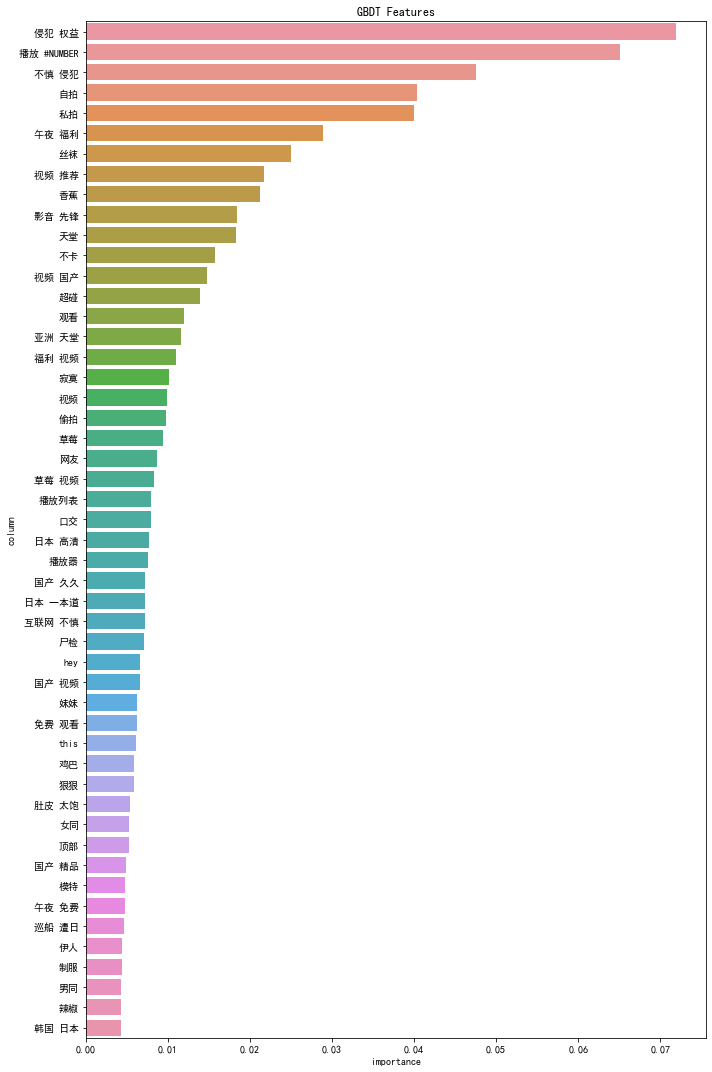

In [53]:
#特征重要性可视化
import matplotlib.pylab as plt
import seaborn as sns
plt.rcParams['font.sans-serif'] = ['SimHei'] #中文乱码

def lgb_importance():
    feature_names_pd = pd.DataFrame({'column': tfv.get_feature_names(),
                                     'importance': clf.feature_importances_,
                                     }).sort_values(by='importance')
    print(feature_names_pd)
    cols = feature_names_pd[["column", "importance"]].groupby("column").mean().sort_values(by="importance",ascending=False)[:50].index
                                         
    best_features = feature_names_pd.loc[feature_names_pd.column.isin(cols)]
    
    plt.figure(figsize=(10, 15))
    sns.barplot(x="importance", y="column", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('GBDT Features')
    plt.tight_layout()

lgb_importance()

In [1365]:
lgb_train = lgb.Dataset(xtrain_tfv, ytrain)
lgb_valid = lgb.Dataset(xvalid_tfv, yvalid, reference=lgb_train)

In [1367]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'l2', 'auc'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}
gbm =lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_valid,
                early_stopping_rounds=5)

[1]	valid_0's auc: 0.993203	valid_0's l2: 0.119776
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.993235	valid_0's l2: 0.108084
[3]	valid_0's auc: 0.993361	valid_0's l2: 0.0977341
[4]	valid_0's auc: 0.994125	valid_0's l2: 0.088518
[5]	valid_0's auc: 0.994346	valid_0's l2: 0.0803385
[6]	valid_0's auc: 0.994525	valid_0's l2: 0.0727831
[7]	valid_0's auc: 0.994519	valid_0's l2: 0.0660777
[8]	valid_0's auc: 0.994435	valid_0's l2: 0.0601262
[9]	valid_0's auc: 0.994462	valid_0's l2: 0.0547521
[10]	valid_0's auc: 0.994435	valid_0's l2: 0.0499096
[11]	valid_0's auc: 0.994456	valid_0's l2: 0.0455797
Early stopping, best iteration is:
[6]	valid_0's auc: 0.994525	valid_0's l2: 0.0727831


In [1396]:
xtrain.shape

(4772,)

In [1404]:
a = np.array([[1,2],[3,4],[5,6]]) 

In [1410]:
np.delete(a,[1,2],0)

array([[1, 2]])

In [171]:
dt=sexy_data['文本数据'][0]
print(model_predict(dt))
print(dt)

(0.9969985814939941, 0.0033677298941831024)
``

``

超91国产自拍

``

``

  * 首页
  * 男生看的最污的app
  * 电影天堂怎么没了
  * 99热这里只有精品
  * 影音先锋tv
  * 橘梨纱 种子

``

``

超91国产自拍

  * 首页
  * 国产自拍
  * 谷姐
  * 嗨哟哟影院
  * 超碰在线
  * 新庄小雪

``

``

  * 超91国产自拍

    久久综合
    狠狠干2015最新版
    宅男频道在线
    橘梨纱在线看免费
    村上里沙作品

``

``

### 超91国产自拍

  * ``

搞搞网

``

超91国产自拍 261 次播放

  * ``

神马神马影院

``

超91国产自拍 2199 次播放

  * ``

手机看片多久

``

超91国产自拍 2152 次播放

  * ``

最新黄色视频

``

超91国产自拍 2110 次播放

  * ``

看了让人湿透的漫画

``

超91国产自拍 275 次播放

  * ``

小草影视

``

超91国产自拍 2863 次播放

  * ``

深爱开心

``

超91国产自拍 1890 次播放

  * ``

古典武侠综合

``

超91国产自拍 1391 次播放

  * ``

大香蕉免费看

``

超91国产自拍 1854 次播放

  * ``

2018天天操

``

超91国产自拍 1645 次播放

  * ``

sss新视频

``

超91国产自拍 218 次播放

  * ``

美女的裤衩

``

超91国产自拍 1168 次播放

  * ``

一路向西2在线观看

``

超91国产自拍 1302 次播放

  * ``

日本厕所小便高清视频

``

超91国产自拍 1928 次播放

  * ``

91在线免费视频

``

超91国产自拍 1831 次播放

  * ``

欧洲三级电影

``

超91国产自拍 1334 次播放

  * ``

147人体艺术

``

超91国产自拍 2389 次播放

  * ``

欧美女同性恋

``

超91国产自拍 2630 次播放

 

In [174]:
import jieba
import re
import pickle
from langconv import *
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd


def number_normalizer(tokens):
    """ 将所有数字标记映射为一个占位符（Placeholder）。
    对于许多实际应用场景来说，以数字开头的tokens不是很有用，
    但这样tokens的存在也有一定相关性。 通过将所有数字都表示成同一个符号，可以达到降维的目的。
    """
    return ("#NUMBER" if token[0].isdigit() else token for token in tokens)


def Traditional2Simplified(sentence):
    """
    将sentence中的繁体字转为简体字
    :param sentence: 待转换的句子
    :return: 将句子中繁体字转换为简体字之后的句子
    """
    sentence = Converter('zh-hans').convert(sentence)
    return sentence


class NumberNormalizingVectorizer(TfidfVectorizer):
    def build_tokenizer(self):
        tokenize = super(NumberNormalizingVectorizer, self).build_tokenizer()
        return lambda doc: list(number_normalizer(tokenize(doc)))


stwlist = [line.strip() for line in
           open(r'F:\work\任务\2021.3.8 NLP\chinese_stopword.txt', 'r', encoding='utf-8').readlines()]

# 数据处理
httpcom = re.compile(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b')  # 去除网址
com_pre = re.compile(r"[a-zA-Z0-9/]+/")
com = re.compile(r"[a-zA-Z0-9/]+.com")  # 去除com
gif = re.compile(r"[a-zA-Z0-9/]+.gif")  # 去除gif
jpg = re.compile(r"[a-zA-Z0-9/]+.jpg")  # 去除jpg
png = re.compile(r"[a-zA-Z0-9/]+.png")  # 去除png
fil = re.compile('[’!"#$%&\'()*+,-./:：;<=>?@～，。?★☆©×»／、…【】《》『』「」←→（）？“”‘’！[\\]^_`{|}~]+', re.UNICODE)  # 去除特殊字符
space = re.compile(r' +')  # 多空格替换为一个空格


def data_procession(dt):
    # dt = re.sub("[A-Za-z0-9\!\%\[\]\,\。]", " ", dt)
    k = Traditional2Simplified(dt).lower()
    k = httpcom.sub(' ', k)
    k = com_pre.sub(' ', k)
    k = com.sub(' ', k)
    k = gif.sub(' ', k)
    k = jpg.sub(' ', k)
    k = png.sub(' ', k)
    k = fil.sub(' ', k)
    k = k.replace('\n', ' ')  # 去除  换行符
    k = k.replace('\ufeff', '')
    k = k.replace('\ue604', '')
    k = k.replace('\ue6a9', '')
    k = k.replace('\ue64c', '')
    k = k.replace('\ue679', '')
    k = k.replace('\ue608', '')
    k = space.sub(' ', k)
    return k


def text_process(dt):
    dt = data_procession(dt)
    dt = jieba.cut(dt)
    dt = ' '.join(dt)
    return [dt]


gam_tfv = pickle.load(open(r"F:\work\任务\2021.3.8 NLP\model\tfidf_5W20_gamble.pickle", 'rb'), encoding='iso-8859-1')
sex_tfv = pickle.load(open(r"F:\work\任务\2021.3.8 NLP\model\tfidf_5W20.pickle", 'rb'), encoding='iso-8859-1')
gam_clf = pickle.load(open(r"F:\work\任务\2021.3.8 NLP\model\gbdt_5W20_gamble_6.pkl", 'rb'), encoding='iso-8859-1')
sex_clf = pickle.load(open(r"F:\work\任务\2021.3.8 NLP\model\gbdt_5W20_5.pkl", 'rb'), encoding='iso-8859-1')
gam_lbl_enc = pickle.load(open(r"F:\work\任务\2021.3.8 NLP\model\LabelEncoder_gam.pickle", 'rb'), encoding='iso-8859-1')
sex_lbl_enc = pickle.load(open(r"F:\work\任务\2021.3.8 NLP\model\LabelEncoder_sex.pickle", 'rb'), encoding='iso-8859-1')
sensitive_words = pd.read_excel(r'F:\work\任务\2021.3.8 NLP\敏感词.xlsx')
sensitive_words_dict = {}
for i in sensitive_words.index:
    word = sensitive_words['name'][i]
    cate = sensitive_words['type'][i]
    sensitive_words_dict.setdefault(cate, [])
    sensitive_words_dict[cate].append(word)
with open(r'F:\work\任务\2021.3.8 NLP\funNLP-master\data\敏感词库\色情词库.txt', 'r', encoding="utf-8") as f:
    for line in f:
        sensitive_words_dict['色情'].append(line.replace('\n', ''))
f.close()
with open(r'F:\work\任务\2021.3.8 NLP\funNLP-master\data\敏感词库\敏感词.txt', 'r', encoding="utf-8") as f:
    for line in f:
        sensitive_words_dict.setdefault('其他', [])
        sensitive_words_dict['其他'].append(line.replace('\n', ''))


def get_gamble_words(text):
    text = re.sub("[A-Za-z0-9\!\%\[\]\,\。]", "", text)
    tmp = list(set(text.split(' ')).intersection(set(sensitive_words_dict['博彩'])))
    return tmp


def get_sexy_words(text):
    text = re.sub("[A-Za-z0-9\!\%\[\]\,\。]", "", text)
    tmp = list(set(text.split(' ')).intersection(set(sensitive_words_dict['色情'])))
    return tmp


def gam_model_predict(dt):
    dt = text_process(dt)
    sen_words = get_gamble_words(dt)
    dt_tfv = gam_tfv.transform(dt)
    gam_predictions_proba = gam_clf.predict_proba(dt_tfv)
    return gam_predictions_proba[0, gam_lbl_enc.transform(['博彩负样本'])[0]], sen_words


def sex_model_predict(dt):
    dt = text_process(dt)
    sen_words = get_sexy_words(dt)
    dt_tfv = sex_tfv.transform(dt)
    sex_predictions_proba = sex_clf.predict_proba(dt_tfv)
    return sex_predictions_proba[0, sex_lbl_enc.transform(['色情负样本'])[0]], sen_words

KeyboardInterrupt: 

In [191]:
def get_gamble_words(text):
    text = re.sub("[A-Za-z0-9\!\%\[\]\,\。]", "", text)
    tmp = list(set(text.split(' ')).intersection(set(sensitive_words_dict['博彩'])))
    return tmp


def get_sexy_words(text):
    text = re.sub("[A-Za-z0-9\!\%\[\]\,\。]", "", text)
    tmp = list(set(text.split(' ')).intersection(set(sensitive_words_dict['色情'])))
    return tmp


def gam_model_predict(dt):
    dt = text_process(dt)
    sen_words = get_gamble_words(dt[0])
    dt_tfv = gam_tfv.transform(dt)
    gam_predictions_proba = gam_clf.predict_proba(dt_tfv)
    return gam_predictions_proba[0, gam_lbl_enc.transform(['博彩负样本'])[0]], sen_words


def sex_model_predict(dt):
    dt = text_process(dt)
    sen_words = get_sexy_words(dt[0])
    dt_tfv = sex_tfv.transform(dt)
    sex_predictions_proba = sex_clf.predict_proba(dt_tfv)
    return sex_predictions_proba[0, sex_lbl_enc.transform(['色情负样本'])[0]], sen_words

In [207]:
dt="![Ty8天游平台注册|Ty8天游登录网站|天游娱乐平台【官方网址】](/skin/images/logo.png)\n\n信誉、稳定、长久、实力\n\n尽在Ty8天游娱乐平台\n\n  * 网站首页\n  * 关于我们\n\n__\n\n  * 界面赏析\n\n__\n\n登录界面\n\n注册界面\n\n投注界面\n\n测速界面\n\n  * 新闻资讯\n\n__\n\n  * 平台展示\n\n__\n\n  * 天游责任\n\n__\n\n  * 平台公告\n\n__\n\n  * Ty8天游注册\n\n__\n\n  * Ty8天游登录\n\n__\n\n  * 客服QQ\n\n__\n\n**网站公告:** Ty8天游娱乐平台祝广大新老会员朋友生活愉快,多多中大奖!无限畅爽，随时随地，投注赢钱乐翻天！\n\nABOUT US **关于我们**\n\n信誉、稳定、长久、实力 尽在Ty8天游娱乐\n\nTy8天游娱乐平台是世界领先的在线游戏供应商，一直以来与世界多家顶级游戏软件供应商保持良好的合作关系。\n\nTy8天游娱乐作为知名的在线娱乐公司，总部成立于2009年8月，位于菲律宾国并接受与认真执行遵守当地相关法律，自成立以来致力提供最广范围并最具竞争力的产品。\n\n##  Ty8天游的承諾\n\n作为国际专业的网上游戏运营企业，我们为每一位客户提供最及时、最安全、最准确的数据，以及全方位的国际化服务。\n同时，Ty8天游平台全部游戏设计均采用世界最领先的软件。我们更聘请了多位资深计算机专家给公司设计和提供软硬件设施维护服务，以提供最佳的技术支援，确保客户能无时无刻享受到最优质的游戏服务。\n我们承诺，置身于Ty8天游平台的客户，不论参与的是真人游戏，还是其他网上游戏，也能享有极具价值的娱乐回报，同时，每名客的资讯户保密性对我们来说是最重要的。我们承诺，将继续不遗余力地坚持严格实行保密和隐私制度。\n\n##  最佳选择\n\n我们向广大的会员提供包括\n时时彩、体育娱乐、真人娱乐城、快乐彩和PT电子游戏。我们为您提供最好的彩票奖金及娱乐赔率。彩票游戏更是提供多项大型第三方公证类彩种，包括重庆时时彩、江西时时彩、新疆时时彩，11选5与福彩3D等。\n\n我们是首家提供全方位娱乐的线上公司。\n\n##  更具网络娱乐价值\n\n我们承诺提供给您最具价值的娱乐无论您在玩什么样的游戏。如果您相信您有这方面的知识可以预测出您喜爱的彩票类开奖的正确结果 –\n那么您将在天游找到您娱乐的最佳价值。\n\n##  安全系统\n\n一个坚实，稳定与安全的娱乐系统\n\nTy8天游系统的基础在设置和系统安全方面是一个类似被大型财政机构所使用的系统基础。您的信息保密性对我们来说是最重要的而且我们将坚持实行严格保密和隐私制度。\n\nTy8天游提供128位SSL加密传输与MD5加密密码，在最大程度上保障用户信息的安全。\n\n##  娱乐责任（法律适用）\n\n我们在菲律宾的执照是由FCLRC ('First Cagayan Leisure and Resort\nCorporation')颁发的。这是一家位于Cagayan特别经济区和自由口岸 (CSEZFP)\n的机构，并且是互动游戏的授权者及管理者。CSEZFP通常也简称为CEZA, 是菲律宾唯一一个被菲律宾政府承认并批准的国际性互动游戏经济区。CEZA\n和FCLRC要求他们执照的拥有者使用经过批准的供应商的软件，以确保游戏操作平台对客户是公正及安全的。\n我们将保证提供给您一个完全公证和安全的网络娱乐空间，客户在本公司的所有活动均严格保密，我们绝不会向商业合作公司（包括政府）透漏您的任何资料。\n\n##  Ty8天游的建议\n\nTy8天游提倡您有节制的娱乐行为，我们建议阁下遵守以下一些基本规则：\n\n禁止未满18岁的人士参与娱乐游戏。在加入游戏前，请您确定您已满18周岁。\n\n自定娱乐预算，并按照预算下注，遵守您当地的法律规定。\n\n本站由亚洲及世界上最大的游戏软件公司提供技术合作。\n\n  \n\n我们的真人娱乐城同知名线上真人娱乐公司 BBIN 与 AG 平台进行技术合作。PT电子游戏供应商亦是全球知名 PT\n公司，我们将紧密携手合作，带给您全新线上娱乐体验。\n\n![](/skin/images/bot.png)\n\nTy8天游娱乐平台为每一位客户提供最优质的服务、最完美的体验、最稳定的平台是Ty8注册天游官网的不懈追求。\n\n  * 网站首页\n  * 关于我们\n  * 界面赏析\n  * 新闻资讯\n  * 平台展示\n  * 天游责任\n  * 平台公告\n  * Ty8天游注册\n  * Ty8天游登录\n  * 客服QQ\n\nLinks：Ty8天游平台注册,Ty8天游注册官网,Ty8天游平台网址  \n©2012-2021 Ty8天游娱乐 All Rights Reserved 版权所有 www.sunxen.com\n\n  * ![在线QQ](/skin/images/qq-ico.png)\n  * ![返回顶部](/skin/images/top-ico.png)\n\n"

In [275]:
gam_model_predict(dt)

(0.04633780634999218, ['发牌', '赔率', '赌场', '彩票', '博彩'])

In [210]:
pd.__version__

'0.25.1'

In [274]:
dt='澳门首家线上赌场上线啦，性感荷官在线发牌，陪您HIGH翻天，给您不一样的博彩体验，并提供各类彩票游戏，时时彩，业界赔率最高，以小博大，紧张刺激'+p['文本数据'][5][:1000]
dt

'澳门首家线上赌场上线啦，性感荷官在线发牌，陪您HIGH翻天，给您不一样的博彩体验，并提供各类彩票游戏，时时彩，业界赔率最高，以小博大，紧张刺激  * #### 教育督导\n\n    * #### 督导动态\n\n    * #### 政策文件\n\n    * #### 督学绩效\n\n  * #### 首页\n\n  * #### 新闻中心\n\n    * #### 图文资讯\n\n    * #### 媒体聚焦\n\n    * #### 特别关注\n\n  * #### 教师发展\n\n    * #### 教师风采\n\n    * #### 科研讯息\n\n    * #### 师资培训\n\n    * #### 课题管理\n\n      * #### “十二五”课题\n\n      * #### “十三五”课题\n\n    * #### 品味书香\n\n  * #### 学生发展\n\n    * #### 社团掠影\n\n    * #### 家校合育\n\n    * #### 心灵驿站\n\n    * #### DSH Pioneer\n\n    * #### 团队风采\n\n    * #### 榜上有名\n\n  * #### 党团工会\n\n    * #### 党建园地\n\n    * #### 工会之家\n\n    * #### 团队工作\n\n  * #### 教学管理\n\n    * #### 多彩教研\n\n    * #### 学科特色\n\n  * #### 后勤管理\n\n    * #### 安全卫生\n\n    * #### 教育装备\n\n    * #### 每周菜单\n\n    * #### 学校采购\n\n  * #### 校务公开\n\n    * #### 关于DSH\n\n      * #### 学校简介\n\n      * #### 文化内涵\n\n      * #### 校园地图\n\n    * #### 招生信息\n\n    * #### 招聘信息\n\n    * #### 公示公告\n\n    * #### 政策法规\n\n    * #### 教育行风建设\n\n      * #### 学校简介\n\n      * #### 工作作风\n\n      

In [2]:
import pandas as pd